## Comparison of error in total energy between simulations of the elastic pendulum performed in polar and Cartesian coordinates

Symplectic Euler method.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from itertools import combinations
from datetime import datetime

In [4]:
from matplotlib.gridspec import GridSpec

In [5]:
from elastic_pendulum_simulation import ElasticPendulumSimulationSymplecticEuler

In [6]:
def local_extrema_iarray(a):
    d = np.diff(a)
    s = np.sign(d)
    d2 = np.diff(s)
    iarray = d2!=0
    iarray = np.pad(iarray, 1, 'minimum')
    return iarray

In [7]:
from dataclasses import dataclass, InitVar, field

@dataclass
class SimulationResult:
    sim: InitVar
    yn_: np.ndarray
    tn_: np.ndarray
    
    T_: np.ndarray = field(init=False)
    U_: np.ndarray = field(init=False)
    E_tot_: np.ndarray = field(init=False)
    PI_z_: np.ndarray = field(init=False)
    
    x_n_: np.ndarray = field(init=False)
    y_n_: np.ndarray = field(init=False)
    x_circ_n_: np.ndarray = field(init=False)
    y_circ_n_: np.ndarray = field(init=False)
    p_x_n_: np.ndarray = field(init=False)
    p_y_n_: np.ndarray = field(init=False)
    r_n_: np.ndarray = field(init=False)
    phi_n_: np.ndarray = field(init=False)
    r_circ_n_: np.ndarray = field(init=False)
    phi_circ_n_: np.ndarray = field(init=False)
    p_r_n_: np.ndarray = field(init=False)
    p_phi_n_: np.ndarray = field(init=False)
    
    E_min_: float = field(init=False)
    
    def __post_init__(self, sim):
        self.T_ = self.calculate_T_(self.yn_, sim)
        self.U_ = self.calculate_U_(self.yn_, sim)
        self.E_tot_ = self.T_ + self.U_
        self.PI_z_ = self.calculate_PI_z_(self.yn_, sim)
        self.E_min_ = self.calculate_E_min_(sim)
        
        (self.x_n_, self.y_n_, 
         self.x_circ_n_, self.y_circ_n_, 
         self.p_x_n_, self.p_y_n_, 
         self.r_n_, self.phi_n_, 
         self.r_circ_n_, self.phi_circ_n_, 
         self.p_r_n_, self.p_phi_n_) = self.calculate_coords_(self.yn_, sim)
        
    def calculate_E_min_(self, sim):
        return -0.5 * (sim.m_**2 * sim.g_**2)/(sim.s_) - sim.m_*sim.g_*sim.l_

    def calculate_E_tot_(self, yn_, sim):
        T_ = calculate_T_(yn_, sim)
        U_ = calculate_U_(yn_, sim)
        return T_ + U_

    def calculate_T_(self, yn_, sim):
        if "rphi" in sim.model_name:
            if "lagrange" in sim.model_name:
                r_circ_n_, r_n_, phi_circ_n_, phi_n_ = yn_
                return 0.5 * sim.m_ * (r_circ_n_**2 + r_n_**2 * phi_circ_n_**2)
            if "hamilton" in sim.model_name:
                r_n_, phi_n_, p_r_n_, p_phi_n_  = yn_
                return 0.5 / sim.m_ * (p_r_n_**2 + (p_phi_n_/r_n_)**2)
        elif "xy" in sim.model_name:
            if 'lagrange' in sim.model_name:
                x_circ_n_, x_n_, y_circ_n_, y_n_ = yn_
                return 0.5 * sim.m_ * (x_circ_n_**2 + y_circ_n_**2)
            if 'hamilton' in sim.model_name:
                x_n_, y_n_, p_x_n_, p_y_n_  = yn_
                return 0.5 / sim.m_ * (p_x_n_**2 + p_y_n_**2)

    def calculate_U_(self, yn_, sim):
        if "rphi" in sim.model_name:
            if "lagrange" in sim.model_name:
                r_circ_n_, r_n_, phi_circ_n_, phi_n_ = yn_
                return 0.5 * sim.s_ * (r_n_ - sim.l_)**2 - sim.m_ * sim.g_ * r_n_ * np.cos(phi_n_)
            if "hamilton" in sim.model_name:
                r_n_, phi_n_, p_r_n_, p_phi_n_  = yn_
                return 0.5 * sim.s_ * (r_n_ - sim.l_)**2 - sim.m_ * sim.g_ * r_n_ * np.cos(phi_n_)
        elif "xy" in sim.model_name:
            if 'lagrange' in sim.model_name:
                x_circ_n_, x_n_, y_circ_n_, y_n_ = yn_
                return 0.5 * sim.s_ * (np.sqrt(x_n_**2 + y_n_**2) - sim.l_)**2 + sim.m_ * sim.g_ * y_n_
            if 'hamilton' in sim.model_name:
                x_n_, y_n_, p_x_n_, p_y_n_  = yn_
                return 0.5 * sim.s_ * (np.sqrt(x_n_**2 + y_n_**2) - sim.l_)**2 + sim.m_ * sim.g_ * y_n_

    def calculate_PI_z_(self, yn_, sim):
        if "rphi" in sim.model_name:
            if "lagrange" in sim.model_name:
                r_circ_n_, r_n_, phi_circ_n_, phi_n_ = yn_
                return self.m * r_n_**2 * phi_circ_n_
            if "hamilton" in sim.model_name:
                r_n_, phi_n_, p_r_n_, p_phi_n_  = yn_
                return p_phi_n_
        elif "xy" in sim.model_name:
            if 'lagrange' in sim.model_name:
                x_circ_n_, x_n_, y_circ_n_, y_n_ = yn_
                return sim.m_ * (x_n_ * y_circ_n_ - y_n_*x_circ_n_)
            if 'hamilton' in sim.model_name:
                x_n_, y_n_, p_x_n_, p_y_n_  = yn_
                return (x_n_ * p_y_n_ - y_n_ * p_x_n_)

    def calculate_coords_(self, yn_, sim):
        # r-phi
        if "rphi" in sim.model_name:
            if "lagrange" in sim.model_name:
                r_circ_n_, r_n_, phi_circ_n_, phi_n_ = yn_

                p_r_n_ = sim.m_ * r_circ_n_
                p_phi_n_ = sim.m_ * r_n_**2 * phi_circ_n_

            if "hamilton" in sim.model_name:
                r_n_, phi_n_, p_r_n_, p_phi_n_  = yn_
                r_circ_n_ = p_r_n_ / sim.m_
                phi_circ_n_ = p_phi_n_ / (sim.m_ * r_n_**2)

            x_circ_n_ = + r_circ_n_ * np.sin(phi_n_) + r_n_ * phi_circ_n_ * np.cos(phi_n_)
            y_circ_n_ = -r_circ_n_ * np.cos(phi_n_) + r_n_ * phi_circ_n_ * np.sin(phi_n_)

            x_n_ = + r_n_ * np.sin(phi_n_)
            y_n_ = - r_n_ * np.cos(phi_n_)
            p_x_n_ = x_circ_n_ * sim.m_
            p_y_n_ = y_circ_n_ * sim.m_
        # x-y 
        elif "xy" in sim.model_name:
            if 'lagrange' in sim.model_name:
                x_circ_n_, x_n_, y_circ_n_, y_n_ = yn_
                p_x_n_ = x_circ_n_ * sim.m_
                p_y_n_ = y_circ_n_ * sim.m_
            if 'hamilton' in sim.model_name:
                x_n_, y_n_, p_x_n_, p_y_n_  = yn_
                x_circ_n_ = p_x_n_ / sim.m_
                y_circ_n_ = p_y_n_ / sim.m_

            r_n_ = np.sqrt(x_n_**2 + y_n_**2)
            phi_n_ = np.arctan2(x_n_, -y_n_)

            r_circ_n_ = (2*x_n_*x_circ_n_+2*y_n_*y_circ_n_)/(2*np.sqrt(x_n_**2 + y_n_**2))
            phi_circ_n_ = (x_n_ * y_circ_n_ - x_circ_n_ * y_n_)/(x_n_**2 + y_n_**2)

            p_r_n_ = sim.m_ * r_circ_n_
            p_phi_n_ = sim.m_ * r_n_**2 * phi_circ_n_
        
        phi_n_ = phi_n_ % (2*np.pi)

        return x_n_, y_n_, x_circ_n_, y_circ_n_, p_x_n_, p_y_n_, r_n_, phi_n_, r_circ_n_, phi_circ_n_, p_r_n_, p_phi_n_

In [8]:
font_size = 10
smaller_font_size = 0.8*font_size

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": font_size,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.constrained_layout.use": True,
    "axes.axisbelow" : True,
    }
)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage[utf8]{inputenc}')

tab10 = cm.tab10(np.linspace(0,1,10))

In [9]:
dpi = 600

In [10]:
mm_to_in = 0.03937

In [12]:
timestamp = datetime.now().strftime("%y%m%d_%H%M%S")

In [13]:
## Elastic pendulum

l_example1_SI = 0.4  ## resting length of spring / m
m_example1_SI = 0.8  ## mass / kg
s_example1_SI = 93.  ## spring stiffness / ( N/m = kg/s^2 )

mu_example1 = 0  ## drag: -k * |v|^mu * v
k_example1_SI = 0.0  ## drag coefficient / (N/(m/s)^(mu+1))

## Realizing the quantities that are used as units:
l_u_example1_SI = l_example1_SI
l_example1_ = l_example1_SI/l_u_example1_SI
m_u_example1_SI = m_example1_SI
m_example1_ = m_example1_SI/m_u_example1_SI
t_u_example1_SI = 1/np.sqrt( s_example1_SI/m_example1_SI )

g_example1_ = 0.02

k_example1_ = k_example1_SI / (m_u_example1_SI * l_u_example1_SI**(-mu_example1) * t_u_example1_SI**(mu_example1-1))

## Realizing the derived quantities of the model:
s_example1_ = s_example1_SI / ( m_u_example1_SI/t_u_example1_SI**2 )

In [14]:
alpha_s_example1_ = np.sqrt(s_example1_/m_example1_)
alpha_g_example1_ = np.sqrt(g_example1_/l_example1_)

In [15]:
print(f"{mu_example1=}")
print(f"{l_example1_=}")
print(f"{m_example1_=}")
print(f"{g_example1_=}")
print(f"{k_example1_=}")
print(f"{s_example1_=}")
print(f"{alpha_s_example1_=}")
print(f"{alpha_g_example1_=}")

mu_example1=0
l_example1_=1.0
m_example1_=1.0
g_example1_=0.02
k_example1_=0.0
s_example1_=1.0000000000000002
alpha_s_example1_=1.0
alpha_g_example1_=0.1414213562373095


In [16]:
## Realizing the free quantities for the numerical realization:
# tmax_example_1_ = 10000  ## defines the final time
tmax_example_1_ = 50000  ## defines the final time
Dt_example_1_ = 0.2 ## defines the time step
symplectic_euler_variant_example_1 = 'position_first' ## defines the variant of the symplectice Euler to be used

## Realizing the derived quantities for the numerical realization:
J_example_1 = int( np.ceil( tmax_example_1_/Dt_example_1_ ) )  ## the number of time steps

In [18]:
## Simulation 1

name_example1 = 'szimpl. Euler (B), $x{-}y$'

model_example1 = 'hamilton_xy_undamped'

model_parameters_example1 = {
    'l_' : l_example1_,
    'm_' : m_example1_,
    'g_' : g_example1_,
    'k_' : k_example1_,
    's_' : s_example1_,
    'mu' : mu_example1,
}

simulation_parameters_example1 = {
    'tmax_' : tmax_example_1_,
    'Dt_' : Dt_example_1_,
    'symplectic_euler_variant' : symplectic_euler_variant_example_1,
    'J' : J_example_1,
    'name' : name_example1
}

model_variable_names_example1 = ['x_', 'y_', 'p_x_', 'p_y_']

In [19]:
sim1 = ElasticPendulumSimulationSymplecticEuler(model=model_example1,
                                                model_variable_names=model_variable_names_example1,
                                                model_parameters=model_parameters_example1,
                                                simulation_parameters=simulation_parameters_example1)

In [20]:
## Realizing the free quantities for the numerical realization:
tmax_example_3_ = tmax_example_1_  ## defines the final time
Dt_example_3_ = Dt_example_1_ ## defines the time step
symplectic_euler_variant_example_3 = 'position_first' ## defines the variant of the symplectice Euler to be used

## Realizing the derived quantities for the numerical realization:
J_example_3 = int( np.ceil( tmax_example_3_/Dt_example_3_ ) )  ## the number of time steps

In [21]:
## Simulation 3

name_example3 = r'szimpl. Euler (B), $r{-}\theta$'

model_example3 = 'hamilton_rphi_undamped'

model_parameters_example3 = {
    'l_' : l_example1_,
    'm_' : m_example1_,
    'g_' : g_example1_,
    'k_' : k_example1_,
    's_' : s_example1_,
    'mu' : mu_example1,
}

simulation_parameters_example3 = {
    'tmax_' : tmax_example_3_,
    'Dt_' : Dt_example_3_,
    'symplectic_euler_variant' : symplectic_euler_variant_example_3,
    'J' : J_example_3,
    'name' : name_example3
}

model_variable_names_example3 = ['r_', 'phi_', 'p_r_', 'p_phi_']

In [22]:
sim3 = ElasticPendulumSimulationSymplecticEuler(model=model_example3,
                                                model_variable_names=model_variable_names_example3,
                                                model_parameters=model_parameters_example3,
                                                simulation_parameters=simulation_parameters_example3)

In [23]:
sims = [sim1, sim3]

In [24]:
def determine_H_errors_l2_(ic_):
    x_0_, y_0_, p_x_0_, p_y_0_ = ic_
    # Átalakítás másik koordináta-rendszerre
    r_0_ = np.sqrt(x_0_**2 + y_0_**2)
    phi_0_ = np.arctan2(x_0_, -y_0_)
    p_r_0_ = -p_y_0_ * np.cos(phi_0_) + p_x_0_ * np.sin(phi_0_)
    p_phi_0_ = r_0_ * (p_x_0_ * np.cos(phi_0_) + p_y_0_ * np.sin(phi_0_))

    ic_example1 = {
        'x_' : x_0_,
        'y_' : y_0_,
        'p_x_' : p_x_0_,
        'p_y_' : p_y_0_,
    }

    ic_example3 = {
        'r_' : r_0_,
        'phi_' : phi_0_,
        'p_r_' : p_r_0_,
        'p_phi_' : p_phi_0_
    }


    ###
    ics = [ic_example1, ic_example3]

    tn_i_ = [None for _ in sims]
    yn_i_ = [None for _ in sims]

    for i, (sim, ic) in enumerate(zip(sims, ics)):
        tn_i_[i], yn_i_[i] = sim.run_simulation(ic=ic, show_progress=False)

    posts = [SimulationResult(sim, yn_, tn_) for (sim, yn_, tn_) in zip(sims, yn_i_, tn_i_)]

    del tn_i_, yn_i_

    return [
        np.sqrt(1/len(post.E_tot_) * np.sum((post.E_tot_-post.E_tot_[0])**2))
        ## np.max(np.abs(post.E_tot_-post.E_tot_[0]))
        for post
        in posts
    ]

In [ ]:
from multiprocessing import Pool

from itertools import product

from tqdm import tqdm

import warnings

import numpy.ma as ma

In [31]:
# Generate initial conditions
p_x_0_i_ = np.array([0])
p_y_0_i_ = np.array([0])

x_0_i_ = np.linspace(-1.7, 1.7, 255)
y_0_i_ = np.linspace(-1.7, 1.7, 255)

In [32]:
ic_i_ = np.array(list(product(x_0_i_, y_0_i_, p_x_0_i_, p_y_0_i_)))

In [33]:
# Run calculations in parallel

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with Pool(processes=126) as pool:
        errors = list(tqdm(pool.imap(
            determine_H_errors_l2_,
            ic_i_,
        ), total=(len(x_0_i_) * len(y_0_i_) * len(p_x_0_i_) * len(p_y_0_i_))))

errors = np.array(errors).T

100%|██████████| 65025/65025 [26:35<00:00, 40.77it/s] 


In [34]:
ic_indices_ = np.array(list(product(range(len(x_0_i_)), range(len(y_0_i_)), range(len(p_x_0_i_)), range(len(p_y_0_i_)))))

In [35]:
errors_structured = np.zeros((
    len(sims),
    len(x_0_i_),
    len(y_0_i_),
    len(p_x_0_i_),
    len(p_y_0_i_),
))

ic_is_structured_ = np.zeros((
    len(x_0_i_),
    len(y_0_i_),
    len(p_x_0_i_),
    len(p_y_0_i_),
))

In [36]:
errors_structured[..., *ic_indices_.T] = errors

In [37]:
def choose_best_variant(errors):
    argmin = np.argmin(errors, axis=0)
    return ma.masked_array(argmin, mask=np.any(np.isnan(errors), axis=0))

def error_difference(errors):
    diff = errors[1] - errors[0]
    return ma.masked_array(diff, mask=np.any(np.isnan(errors), axis=0))

def error_difference_log(errors):
    diff = errors[1] - errors[0]
    diff_abs = np.abs(errors[1] - errors[0])
    diff_absp1 = diff_abs + 1
    diff_log = np.sign(diff) * np.log(diff_absp1)
    return ma.masked_array(diff_log, mask=np.any(np.isnan(errors), axis=0))

In [40]:
dx = x_0_i_[1] - x_0_i_[0]
dy = y_0_i_[1] - y_0_i_[0]

In [41]:
X_0_I_, Y_0_I_, P_X_0_I_, P_Y_0_I_ = np.meshgrid(x_0_i_, y_0_i_, p_x_0_i_, p_y_0_i_, indexing='ij')

In [42]:
H_0_ = 1/2/m_example1_ * (P_X_0_I_**2 + P_Y_0_I_**2) + 1/2 * s_example1_ * (np.sqrt(X_0_I_**2 + Y_0_I_**2) - l_example1_)**2 + m_example1_ * g_example1_ * Y_0_I_
U_spring_0_ = 1/2 * s_example1_ * (np.sqrt(X_0_I_**2 + Y_0_I_**2) - l_example1_)**2
U_g_0_ = m_example1_ * g_example1_ * Y_0_I_

In [43]:
# H_0_ = 1/2/m_example1_ * (P_X_0_I_**2 + P_Y_0_I_**2) + 1/2 * s_example1_ * (np.sqrt(X_0_I_**2 + Y_0_I_**2) - l_example1_)**2 + m_example1_ * g_example1_ * Y_0_I_
# unstable_polar_ = 2*l_example1_ + (2*m_example1_ * g_example1_) / (s_example1_) * np.cos(np.arctan2(Y_0_I_, X_0_I_)) - np.sqrt(X_0_I_**2 + Y_0_I_**2)
unstable_polar_ = 2*l_example1_ + (2*m_example1_ * g_example1_) / (s_example1_) * np.cos(np.arctan2(-X_0_I_, Y_0_I_)) - np.sqrt(X_0_I_**2 + Y_0_I_**2)

In [48]:
# vmin = -1.5e-4
# vmax =  1.5e-4
vmin = -5e-5
vmax =  5e-5
vmin_diff = vmin
vmax_diff = vmax
vmin_single = 0
vmax_single = 1e-2

vmax_log = 5

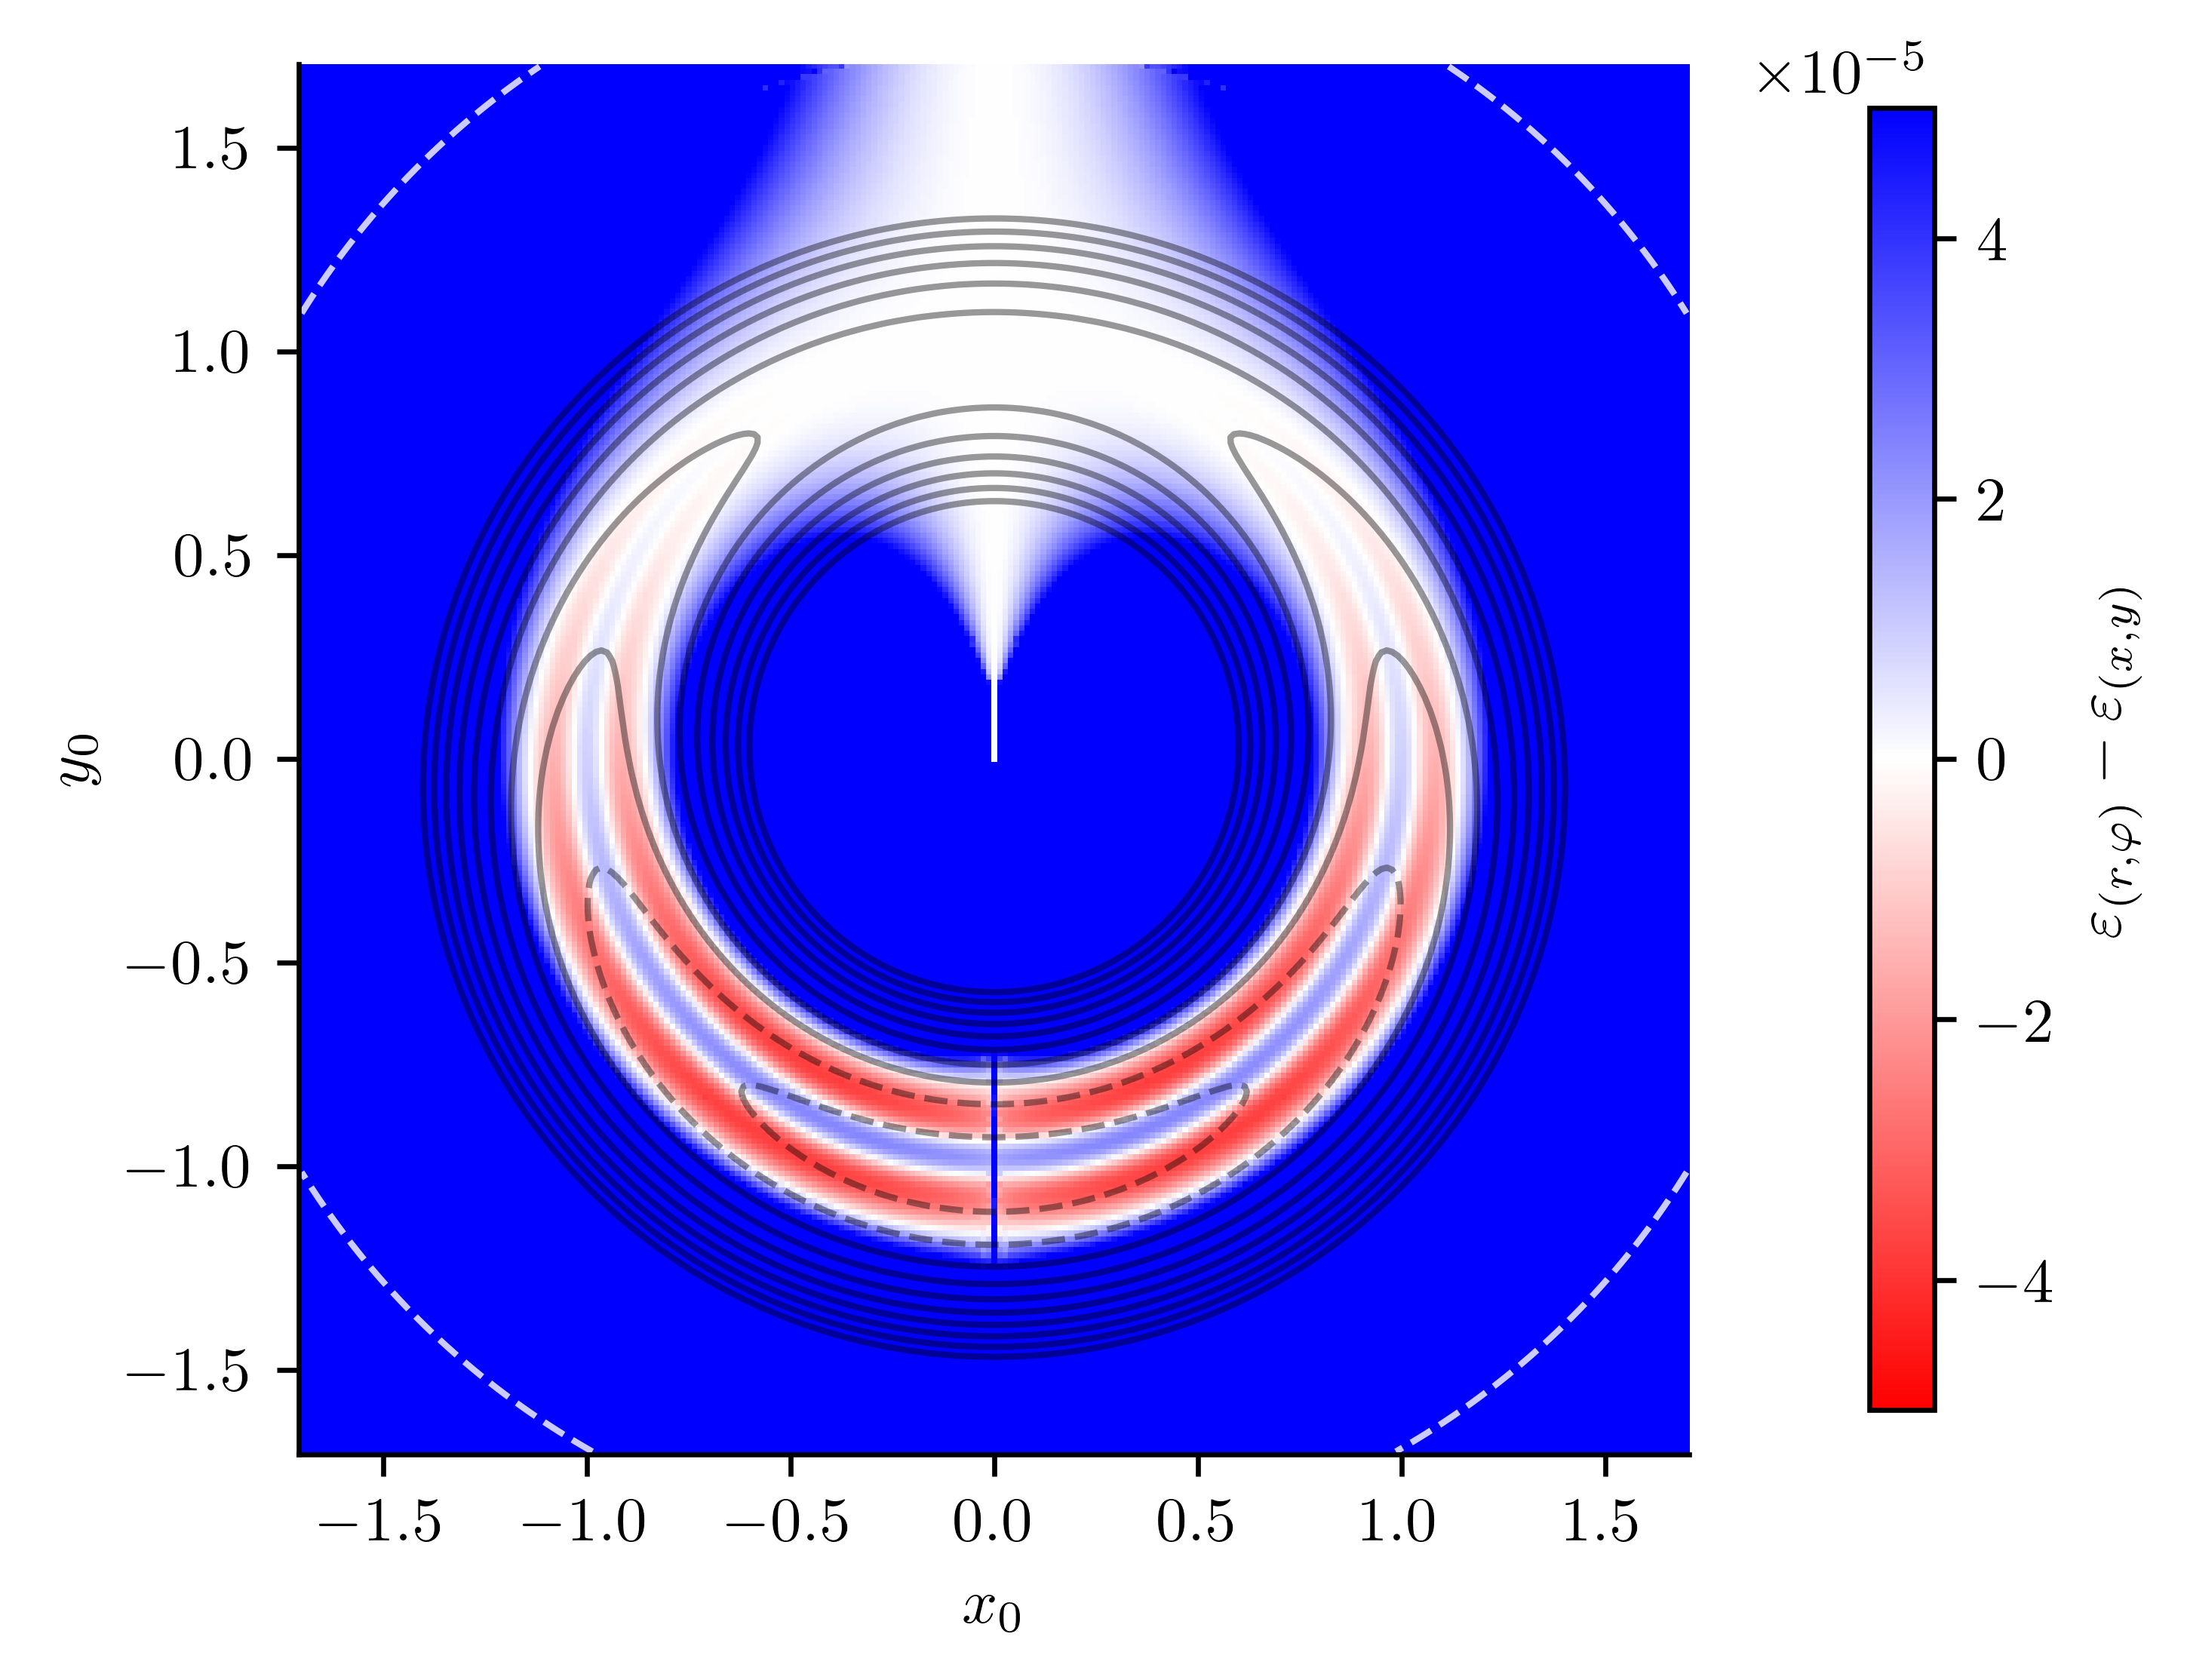

In [51]:
multiplier = 1
fig, ax = plt.subplots(1, 1, figsize=(120*mm_to_in,120*mm_to_in), dpi=600)

im = ax.imshow(
    multiplier * error_difference(errors_structured[..., 0, 0]).T,
    extent=[x_0_i_.min()-dx/2, x_0_i_.max()+dx/2, y_0_i_.min()-dy/2, y_0_i_.max()+dy/2],
    cmap='bwr_r',
    vmin=multiplier * vmin_diff,
    vmax=multiplier * vmax_diff,
)

ax.contour(
    X_0_I_[..., 0, 0],
    Y_0_I_[..., 0, 0],
    H_0_[..., 0, 0],
    levels = np.linspace(-0.08, 0.08, 16),
    colors='k',
    linewidths=1,
    alpha=0.4,
)

ax.contour(
    X_0_I_[..., 0, 0],
    Y_0_I_[..., 0, 0],
    unstable_polar_[..., 0, 0],
    levels = [0],
    colors='white',
    linewidths=1,
    linestyles='--',
    alpha=0.8,
)

cbar = plt.colorbar(
    im,
    ax=ax,
    shrink=0.62,
    label=r'$\varepsilon_{(r,\varphi)} - \varepsilon_{(x,y)}$',
    # format=lambda x, _: f"{x:0.02e}",
)

ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$y_0$')

plt.savefig('{0}-unstable-boundary-smooth.png'.format(timestamp), facecolor='w', bbox_inches='tight', dpi=dpi)

plt.show()